# Bibliotecas e download do dataset

In [6]:
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import os
from keras.models import Sequential
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from keras.applications import InceptionV3
from keras.callbacks import ModelCheckpoint, EarlyStopping
import zipfile
from PIL import Image

In [7]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
skin-cancer-mnist-ham10000.zip: Skipping, found more recently modified local copy (use --force to force download)


In [8]:

zip_ref = zipfile.ZipFile('/content/skin-cancer-mnist-ham10000.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

# Tratamento do Dataset

In [9]:
df = pd.read_csv('/content/hmnist_28_28_RGB.csv')

y = df['label']
x = df.drop(columns = ['label'])

In [10]:
oversample = RandomOverSampler()# oversampler para remediar o problema da quantidade desigual de nevos no dataset
x, y = oversample.fit_resample(x, y)
y = y.reset_index(drop=True)

In [11]:
x = x.values
y = y.values
x = x.reshape(-1, 28, 28, 3)
x= x.astype('float32') / 255.0

X_train, X_test, Y_train, Y_test = train_test_split(x,y, test_size=0.2, random_state=42)

X_train = tf.image.resize(X_train, (75, 75))
X_test = tf.image.resize(X_test, (75, 75))

# Definição do modelo

In [12]:

inceptionv3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(75, 75, 3))
inceptionv3.trainable = False

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [13]:

model = Sequential()

model.add(inceptionv3)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(7, activation='softmax'))

In [14]:
optimizer = Adam(learning_rate=0.0001)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

In [15]:

checkpoint = ModelCheckpoint(
    filepath = '/content/modelo.keras',
    monitor ='val_sparse_categorical_accuracy',
    verbose = True,
    save_best_only = True,
    save_weights_only=False,
    mode = 'max'
)
callback = EarlyStopping(monitor = 'val_loss', patience = 4)


In [16]:
hist = model.fit(X_train, Y_train, epochs=10, validation_data=(X_test, Y_test), callbacks=[checkpoint, callback], verbose = 1)

Epoch 1/10
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.0437 - sparse_categorical_accuracy: 0.6264
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.87376, saving model to /content/modelo.keras
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 63s 37ms/step - loss: 1.0434 - sparse_categorical_accuracy: 0.6265 - val_loss: 0.3633 - val_sparse_categorical_accuracy: 0.8738
Epoch 2/10
1173/1174 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3051 - sparse_categorical_accuracy: 0.8948
Epoch 2: val_sparse_categorical_accuracy improved from 0.87376 to 0.92703, saving model to /content/modelo.keras
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 53s 22ms/step - loss: 0.3051 - sparse_categorical_accuracy: 0.8948 - val_loss: 0.2106 - val_sparse_categorical_accuracy: 0.9270
Epoch 3/10
1172/1174 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1711 - sparse_categorical_accuracy: 0.9397
Epoch 3: val_sparse_categorical_accuracy improved from 0.92703 to 0.95558, saving model to /content/modelo.keras
1174/1174 ━━━━━━━━━━━━

# Métricas e matriz de confusão

In [17]:

acc_treino= max(hist.history['sparse_categorical_accuracy'])
acc_val = max(hist.history['val_sparse_categorical_accuracy'])

print(f'Acurácia Treino : {acc_treino}')
print(f'Acurácia Validação : {acc_val}')


Acurácia Treino : 0.9844732284545898
Acurácia Validação : 0.9694257974624634


In [18]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
accuracy = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred, average='weighted')# weighted por conta do dataset desbalanceado anteriormente
recall = recall_score(Y_test, y_pred, average='weighted')
print(f'Precisão: {precision}')
print(f'Recall: {recall}')
print(f'Acurácia: {accuracy}')

294/294 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step
Precisão: 0.9656456804905854
Recall: 0.9642058165548099
Acurácia: 0.9642058165548099


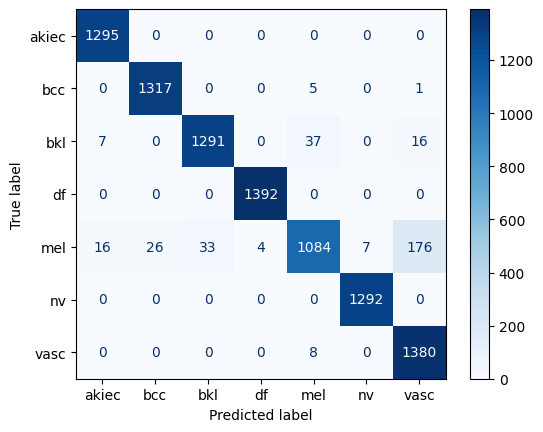

In [19]:

classes = {0: 'akiec', 1: 'bcc', 2: 'bkl', 3: 'df', 4: 'mel', 5:'nv', 6: 'vasc'}
matriz = confusion_matrix(Y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=matriz, display_labels=classes.values())
disp.plot(cmap=plt.cm.Blues)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


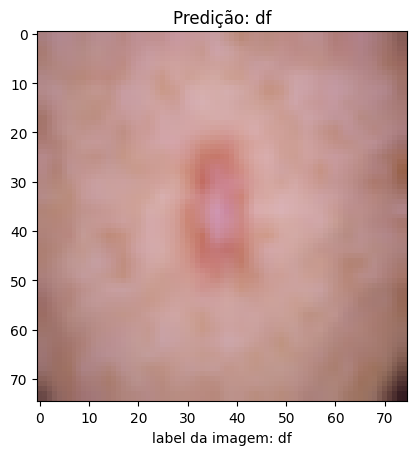

In [20]:
x=43
prev =model.predict(np.expand_dims(X_test[x], axis=0))
predicted_class = tf.argmax(prev, axis=1).numpy()[0]
plt.title(f'Predição: {classes[predicted_class]}')
plt.text(0.5, -0.1,f'label da imagem: {classes[Y_test[x]]}', ha='center', va='center', transform=plt.gca().transAxes)
plt.imshow(X_test[x])# testes em uma imagem do dataset

# Testes com imagens obtidas em laboratório

In [34]:
img_dir = '/content/imagens celular/'
img_rosto = []
img_costas = []
img_pai = []
for file_name in os.listdir(img_dir):
    image_path = os.path.join(img_dir, file_name)

    img = Image.open(image_path)
    img = img.resize((75, 75))
    img_array = np.array(img) / 255.0  #
    img_array = img_array.astype('float32')
    if 'Rosto' in file_name:
      img_rosto.append(img_array)
    elif 'costas' in file_name:
      img_costas.append(img_array)
    elif 'pai' in file_name:
      img_pai.append(img_array)
imagens = np.array(imagens).astype('float32') # tratamento de imagens fora do dataset

In [64]:
titulo_rosto = []
titulo_costas = []
titulo_pai = []
for img in img_rosto:
  imagem = np.expand_dims(img, axis=0)
  prev = model.predict(imagem)
  prev_classe = np.argmax(prev, axis=1)[0]
  titulo_rosto.append(classes[prev_classe])

for img in img_pai:
  imagem = np.expand_dims(img, axis=0)
  prev = model.predict(imagem)
  prev_classe = np.argmax(prev, axis=1)[0]
  titulo_pai.append(classes[prev_classe])

for img in img_costas:
  imagem = np.expand_dims(img, axis=0)
  prev = model.predict(imagem)
  prev_classe = np.argmax(prev, axis=1)[0]
  titulo_costas.append(classes[prev_classe])
# predição realizada nas imagens fotografadas pelo celular

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Text(0.5, 0.1, 'Predição:akiec')

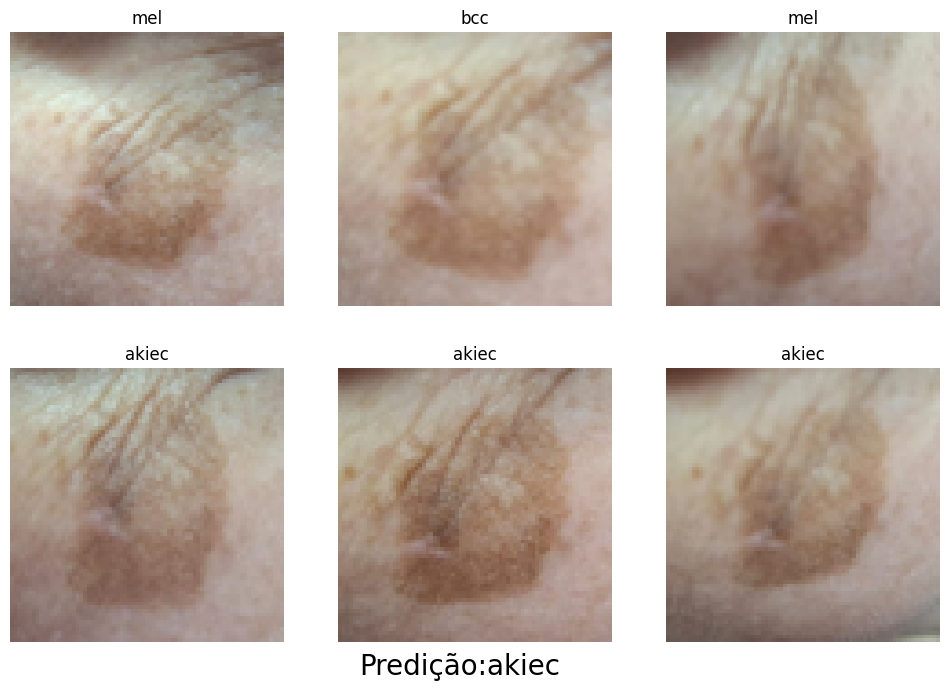

In [65]:
plt.figure(figsize=(12, 8))

for i in range(len(img_rosto)):
    plt.subplot(2, 3, i + 1)  # Organizando as imagens em um grid 2x3
    plt.imshow(img_rosto[i])
    plt.title(titulo_rosto[i])
    plt.axis('off')
moda = max(set(titulo_rosto), key=titulo_rosto.count)
plt.figtext(0.5, 0.1, f'Predição:{moda}', ha='center', va='top', fontsize=20, color='black')

Text(0.5, 0.1, 'Predição:mel')

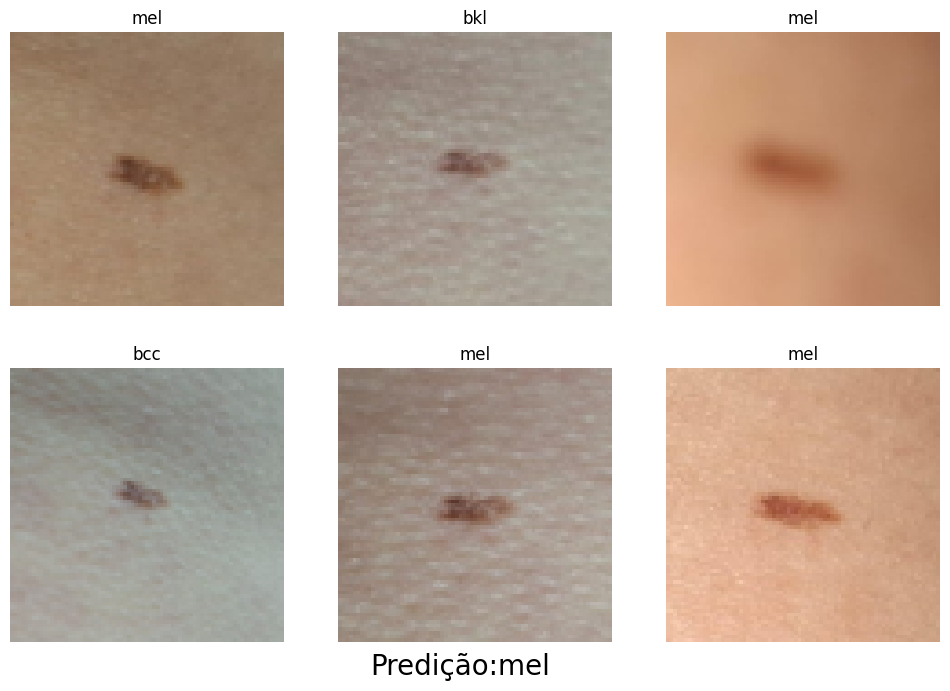

In [66]:
plt.figure(figsize=(12, 8))

for i in range(len(img_costas)):
    plt.subplot(2, 3, i + 1)
    plt.imshow(img_costas[i])
    plt.title(titulo_costas[i])
    plt.axis('off')
moda = max(set(titulo_costas), key=titulo_costas.count)
plt.figtext(0.5, 0.1, f'Predição:{moda}', ha='center', va='top', fontsize=20, color='black')

Text(0.5, 0.1, 'Predição:mel')

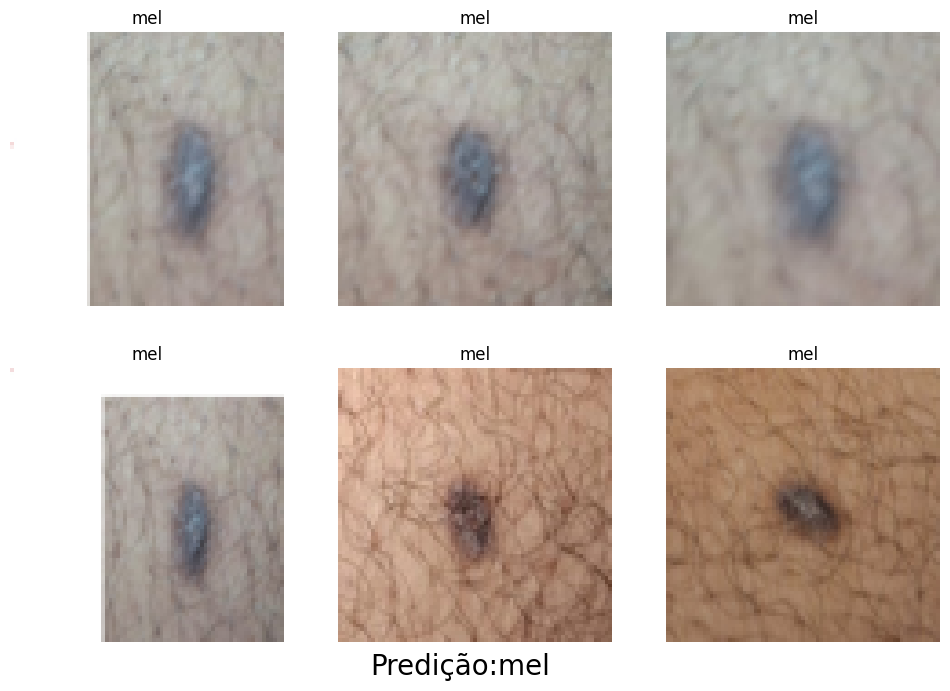

In [67]:
plt.figure(figsize=(12, 8))

for i in range(len(img_pai)):
    plt.subplot(2, 3, i + 1)
    plt.imshow(img_pai[i])
    plt.title(titulo_pai[i])
    plt.axis('off')

moda = max(set(titulo_pai), key=titulo_pai.count)
plt.figtext(0.5, 0.1, f'Predição:{moda}', ha='center', va='top', fontsize=20, color='black')

In [68]:
img_dir = '/content/imagens laboratorio/'
img_lab = []
for file_name in os.listdir(img_dir):
    image_path = os.path.join(img_dir, file_name)

    img = Image.open(image_path)
    img = img.resize((75, 75))
    img_array = np.array(img) / 255.0  #
    img_array = img_array.astype('float32')

    img_lab.append(img_array)

In [74]:
titulo_lab = []
for img in img_lab:
  imagem = np.expand_dims(img, axis=0)
  prev = model.predict(imagem)
  prev_classe = np.argmax(prev, axis=1)[0]
  titulo_lab.append(classes[prev_classe])
# predição realizada nas dermatoscopias obtidas

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


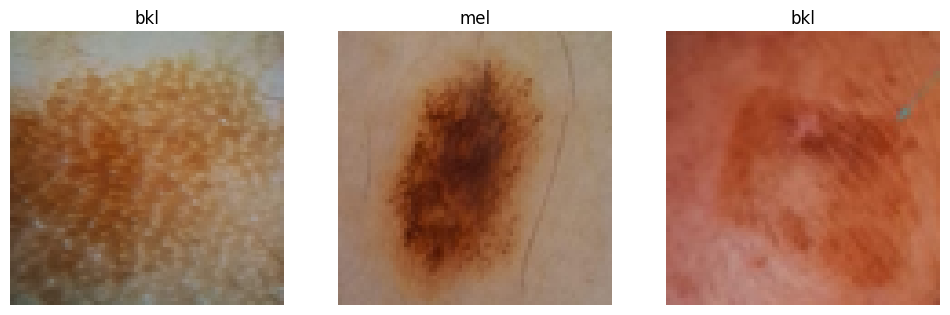

In [73]:
plt.figure(figsize=(12, 8))
for i in range(len(img_lab)):
    plt.subplot(1, 3, i + 1)
    plt.imshow(img_lab[i])
    plt.title(titulo_lab[i])
    plt.axis('off')